In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("yiweilu2033/well-documented-alzheimers-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.02G/4.02G [00:45<00:00, 94.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yiweilu2033/well-documented-alzheimers-dataset/versions/2


In [2]:
import os

def count_images_in_folders(dataset_path):
    folder_counts = {}

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            # Buscar subcarpeta con el mismo nombre (excepto para 'NonDemented')
            subfolder_name = folder if "NonDemented" not in folder else "NonDemented"
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                image_count = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
                folder_counts[folder] = image_count
            else:
               print(f"Subcarpeta no encontrada en: {folder_path}")

    return folder_counts

# Ruta del dataset

image_counts = count_images_in_folders(path)

# Imprimir resultados
for folder, count in image_counts.items():
    print(f"{folder}: {count} imágenes")


VeryMildDemented: 13796 imágenes
NonDemented (2): 63560 imágenes
MildDemented: 5184 imágenes
ModerateDemented: 376 imágenes


In [3]:
import os

def count_images_in_folders(dataset_path):
    folder_counts = {}

    for folder in os.listdir(dataset_path):
        # Omitir la carpeta "ModerateDemented"
        if folder == "ModerateDemented":
            continue

        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            # Buscar subcarpeta con el mismo nombre (excepto para 'NonDemented')
            subfolder_name = folder if "NonDemented" not in folder else "NonDemented"
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                image_count = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
                folder_counts[folder] = image_count
            else:
                print(f"Subcarpeta no encontrada en: {folder_path}")

    return folder_counts

# Ruta del dataset

image_counts = count_images_in_folders(path)

# Imprimir resultados
for folder, count in image_counts.items():
    print(f"{folder}: {count} imágenes")


VeryMildDemented: 13796 imágenes
NonDemented (2): 63560 imágenes
MildDemented: 5184 imágenes


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Base del dataset descargado
base_dir = path  # Asegúrate de que 'path' esté definido correctamente

# Estructura del dataset: categorías válidas (sin ModerateDemented)
category_subfolders = {
    "MildDemented": "MildDemented",
    "VeryMildDemented": "VeryMildDemented",
    "NonDemented (2)": "NonDemented"
}

# Diccionarios para almacenar info
patient_images = {}  # patient_id -> list of (slice_number, path)
patient_labels = {}  # patient_id -> label

# Recorremos cada clase
for category, subfolder in category_subfolders.items():
    category_path = os.path.join(base_dir, category, subfolder)

    if not os.path.exists(category_path):
        print(f"Advertencia: Carpeta no encontrada {category_path}")
        continue

    for img_name in os.listdir(category_path):
        if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        # Extraer patient ID y slice
        parts = img_name.split("_")
        patient_id = "_".join(parts[:3])  # ejemplo: OAS1_0028_MR1
        slice_number = int(parts[-1].replace(".png", "").replace(".jpg", "").replace(".jpeg", "").replace("slice_", ""))

        img_path = os.path.join(category_path, img_name)

        if patient_id not in patient_images:
            patient_images[patient_id] = []

        patient_images[patient_id].append((slice_number, img_path))
        patient_labels[patient_id] = category

# Seleccionar slices: central, central -10, central +10 (si existen)
image_paths = []
patient_ids = []
labels = []

for patient_id, slices in patient_images.items():
    sorted_slices = sorted(slices, key=lambda x: x[0])
    central_index = len(sorted_slices) // 2

    indices_to_take = [central_index - 10, central_index, central_index + 10]

    for idx in indices_to_take:
        if 0 <= idx < len(sorted_slices):
            image_paths.append(sorted_slices[idx][1])
            patient_ids.append(patient_id)
            labels.append(patient_labels[patient_id])


# Crear DataFrame
images_df = pd.DataFrame({
    "image_path": image_paths,
    "patient_id": patient_ids,
    "label": labels
})



In [5]:

# Estratificación por paciente
unique_patient_ids = images_df["patient_id"].unique()
patient_labels_series = images_df.groupby("patient_id")["label"].first()

# Split en pacientes (80% train, 10% val, 10% test)
train_ids, test_ids = train_test_split(
    unique_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_labels_series.loc[unique_patient_ids]
)
train_ids, val_ids = train_test_split(
    train_ids, test_size=0.2, random_state=42,
    stratify=patient_labels_series.loc[train_ids]
)

# Asignar set a cada imagen
set_assignment = []
for pid in patient_ids:
    if pid in train_ids:
        set_assignment.append("train")
    elif pid in val_ids:
        set_assignment.append("val")
    else:
        set_assignment.append("test")

# DataFrame final
final_df = pd.DataFrame({
    "image_path": image_paths,
    "patient_id": patient_ids,
    "label": labels,
    "set": set_assignment
})

# Mostrar tamaños por conjunto
print(f"Tamaño entrenamiento: {sum(final_df['set'] == 'train')}")
print(f"Tamaño validación: {sum(final_df['set'] == 'val')}")
print(f"Tamaño test: {sum(final_df['set'] == 'test')}")
print(final_df.head())


Tamaño entrenamiento: 831
Tamaño validación: 210
Tamaño test: 261
                                          image_path     patient_id  \
0  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0052_MR1   
1  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0052_MR1   
2  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0052_MR1   
3  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0452_MR1   
4  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0452_MR1   

          label    set  
0  MildDemented  train  
1  MildDemented  train  
2  MildDemented  train  
3  MildDemented  train  
4  MildDemented  train  


In [6]:
# Mostrar tamaños por conjunto
print(f"\n Tamaño por conjunto:")
print(f" - Entrenamiento: {sum(final_df['set'] == 'train')}")
print(f" - Validación:    {sum(final_df['set'] == 'val')}")
print(f" - Test:          {sum(final_df['set'] == 'test')}")

# Mostrar conteo por clase total
print("\n Número total de imágenes por clase:")
print(final_df["label"].value_counts())

# Mostrar conteo por clase y conjunto
print("\n Número de imágenes por clase y conjunto:")
print(final_df.groupby(["set", "label"]).size().unstack(fill_value=0))





 Tamaño por conjunto:
 - Entrenamiento: 831
 - Validación:    210
 - Test:          261

 Número total de imágenes por clase:
label
NonDemented (2)     1008
VeryMildDemented     210
MildDemented          84
Name: count, dtype: int64

 Número de imágenes por clase y conjunto:
label  MildDemented  NonDemented (2)  VeryMildDemented
set                                                   
test             18              201                42
train            51              645               135
val              15              162                33


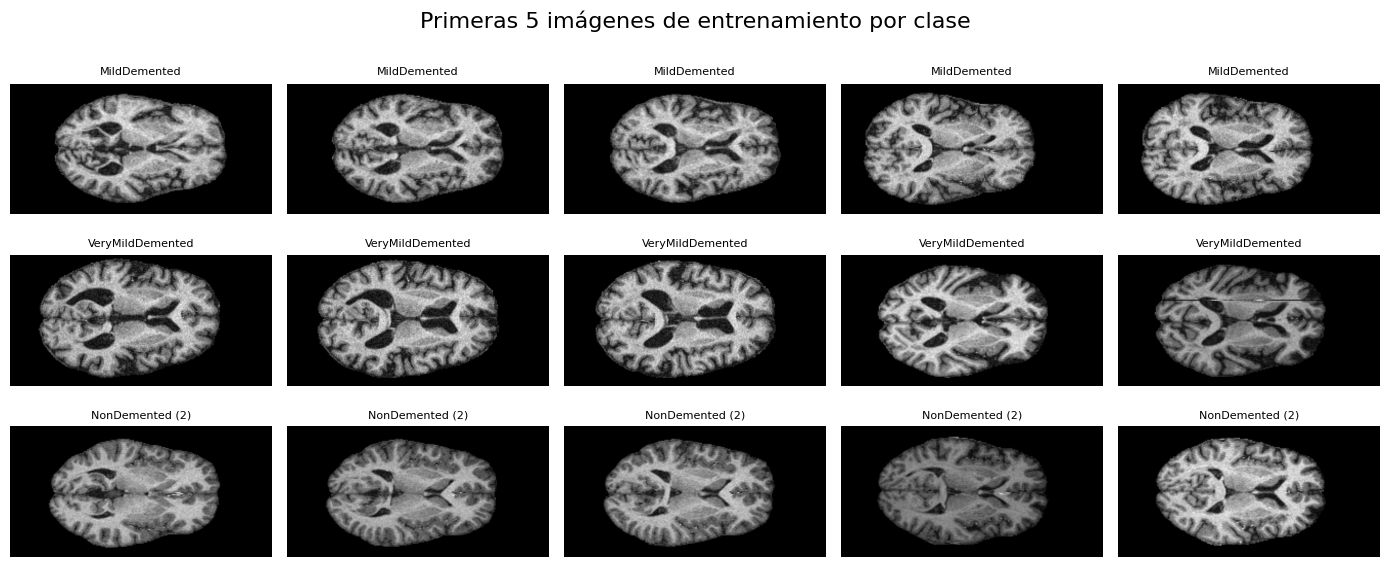

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Asegúrate de que final_df esté ya cargado y tenga las columnas 'label', 'set', y 'image_path'

# Etiquetas a visualizar
categories = ["MildDemented", "VeryMildDemented", "NonDemented (2)"]

# Seleccionar las 5 primeras imágenes por clase del conjunto de entrenamiento
samples = []
for category in categories:
    category_df = final_df[(final_df["label"] == category) & (final_df["set"] == "train")]
    sampled = category_df.head(5)  # Selecciona las 5 primeras
    samples.append(sampled)

# Concatenar en un único DataFrame
sample_df = pd.concat(samples).reset_index(drop=True)

# Mostrar las imágenes
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(14, 6))
fig.suptitle("Primeras 5 imágenes de entrenamiento por clase", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(sample_df):
        img_path = sample_df.loc[i, "image_path"]
        label = sample_df.loc[i, "label"]

        try:
            image = Image.open(img_path)
            ax.imshow(image, cmap='gray')
            ax.set_title(label, fontsize=8)
            ax.axis('off')
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
            ax.set_visible(False)
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # espacio para el título
plt.show()


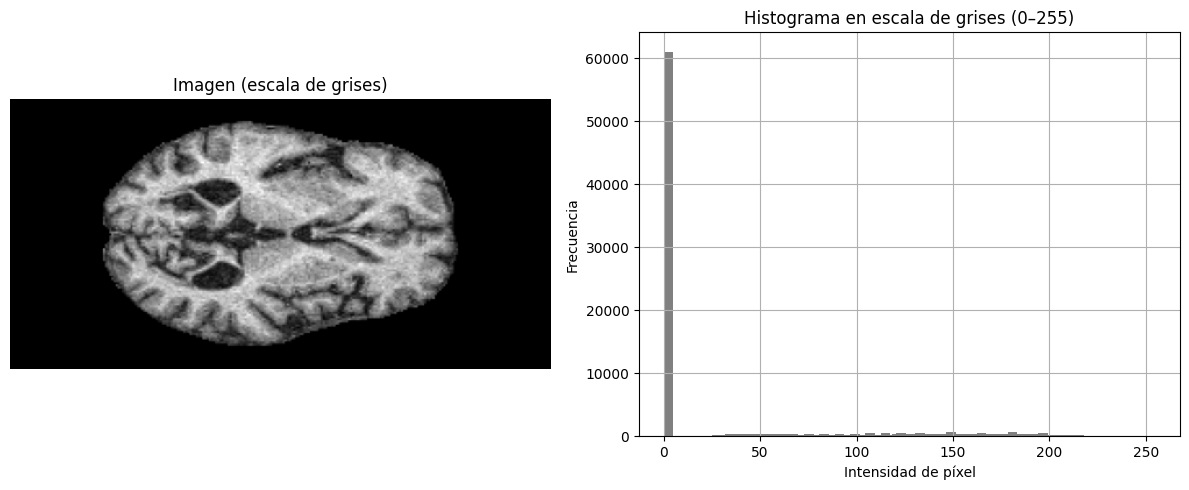

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Filtrar solo las imágenes del conjunto de entrenamiento
train_df = final_df[final_df["set"] == "train"].reset_index(drop=True)

# Obtener el path de la segunda imagen del conjunto de entrenamiento
img_path = train_df.iloc[0]["image_path"]

# Cargar la imagen original
img_original = Image.open(img_path).convert("RGB")

# Convertir a escala de grises (modo "L" = luminancia 8-bit)
img_gray = img_original.convert("L")
img_gray_np = np.array(img_gray)  # Array en rango 0-255

# Mostrar imagen + histograma
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Imagen en grises
axs[0].imshow(img_gray, cmap="gray")
axs[0].set_title("Imagen (escala de grises)")
axs[0].axis("off")

# Histograma
axs[1].hist(img_gray_np.flatten(), bins=256, range=(0, 255), color="gray", width=5)
axs[1].set_title("Histograma en escala de grises (0–255)")
axs[1].set_xlabel("Intensidad de píxel")
axs[1].set_ylabel("Frecuencia")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Transformaciones
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])



# Mapeo de etiquetas a números
label_map = {
    "MildDemented": 2,
    "VeryMildDemented": 1,
    "NonDemented (2)": 0
}

# Dataset personalizado
class AlzheimerCentralSliceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = label_map[self.df.iloc[idx]["label"]]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Dividir el DataFrame final
train_df = final_df[final_df["set"] == "train"]
val_df = final_df[final_df["set"] == "val"]
test_df = final_df[final_df["set"] == "test"]

# Crear datasets con sus respectivas transformaciones
train_dataset = AlzheimerCentralSliceDataset(train_df, transform=base_transform)
val_dataset = AlzheimerCentralSliceDataset(val_df, transform=base_transform)
test_dataset = AlzheimerCentralSliceDataset(test_df, transform=base_transform)

# Crear dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificación
print(f"Tamaño del dataset -> Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"DataLoaders listos con batch_size={batch_size}")


Tamaño del dataset -> Train: 831, Val: 210, Test: 261
DataLoaders listos con batch_size=128


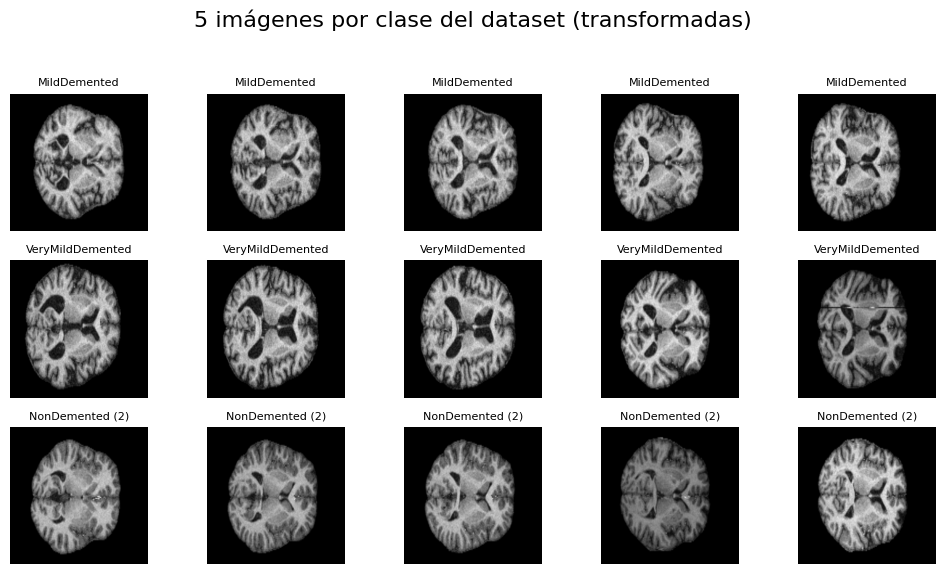

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Invertir el label_map
inv_label_map = {v: k for k, v in label_map.items()}

# Seleccionar 5 imágenes por clase desde el dataset
samples_per_class = 5
class_samples = {label: [] for label in label_map.values()}

for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    if len(class_samples[label]) < samples_per_class:
        class_samples[label].append((img, label))
    if all(len(v) == samples_per_class for v in class_samples.values()):
        break

# Combinar todas las imágenes y etiquetas
images = []
labels = []
for label, items in class_samples.items():
    for img, lbl in items:
        images.append(img)
        labels.append(lbl)

# Mostrar en una cuadrícula: 3 filas x 5 columnas
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle("5 imágenes por clase del dataset (transformadas)", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        img_tensor = images[i]
        img_np = img_tensor.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        ax.imshow(img_np)
        ax.set_title(inv_label_map[labels[i]], fontsize=8)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


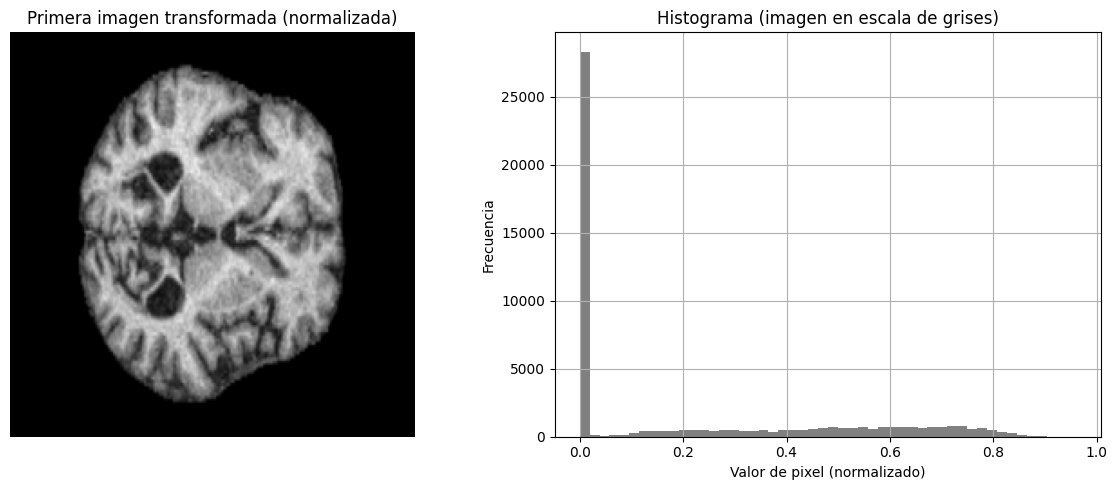

In [11]:
# Obtener la primera imagen transformada (ya normalizada)
img_tensor, label = train_dataset[0]

# Convertir a numpy para visualización
img_np = img_tensor.numpy()

# Convertir a formato [H, W, C] para mostrar como imagen
img_vis = np.transpose(img_np, (1, 2, 0))
img_vis = np.clip(img_vis, 0, 1)

# Crear histograma directo de los valores normalizados
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Mostrar la imagen normalizada
axs[0].imshow(img_vis)
axs[0].set_title("Primera imagen transformada (normalizada)")
axs[0].axis("off")

# Histograma de un canal (ej. canal 0: rojo)
axs[1].hist(img_np[0].flatten(), bins=50, color='gray')
axs[1].set_title("Histograma (imagen en escala de grises)")
axs[1].set_xlabel("Valor de pixel (normalizado)")
axs[1].set_ylabel("Frecuencia")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [12]:
img = images[0]  # Ya transformada


# Ver rango de valores
for i, color in enumerate(["Rojo", "Verde", "Azul"]):
    print(f"{color}: min={img[i].min():.4f}, max={img[i].max():.4f}")


Rojo: min=0.0000, max=0.9608
Verde: min=0.0000, max=0.9608
Azul: min=0.0000, max=0.9608


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=3):  # Ahora tenemos 3 clases en lugar de 4
        super(AlzheimerCNN, self).__init__()

        # Bloque 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bloque 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calcular el tamaño de entrada para la capa densa
        self.flattened_size = self._get_flattened_size()

        # Capas densas
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)  # Ajustado a 3 clases
        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self):
        """Calcula automáticamente el tamaño de la salida antes de la capa fully connected."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)  # Imagen de ejemplo
            x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
            x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Inicializar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerCNN(num_classes=3).to(device)  # Se pasa el nuevo número de clases
print(model)


AlzheimerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from google.colab import files

# 1. Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 2. Función para entrenar usando F1-score como criterio
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    train_accuracies = []  # Lista para guardar la precisión de entrenamiento
    val_losses = []  # Lista para guardar la pérdida de validación
    val_f1_scores = []
    val_accuracies = []
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_preds / total_preds
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())  # Guardamos el accuracy de entrenamiento

        # VALIDACIÓN
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)  # Guardamos la pérdida de validación

                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_val_loss = running_val_loss / len(val_loader.dataset)  # Promedio de la pérdida de validación
        val_losses.append(epoch_val_loss)
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1_scores.append(val_f1)
        val_accuracies.append(val_acc)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "3slicesPaper2Normalization01SGD.pth")
            print(f"Mejor modelo guardado en la época {epoch+1} con F1: {val_f1:.4f}")

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f} - "
              f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores


# 4. Entrenamiento
num_epochs = 25
train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)




Mejor modelo guardado en la época 1 con F1: 0.0905
Epoch 1/25 - Train Loss: 1.0753, Train Accuracy: 0.1625 - Validation Loss: 1.0708, Validation Accuracy: 0.1571, F1 Score: 0.0905
Epoch 2/25 - Train Loss: 1.0660, Train Accuracy: 0.1625 - Validation Loss: 1.0629, Validation Accuracy: 0.1571, F1 Score: 0.0905
Epoch 3/25 - Train Loss: 1.0591, Train Accuracy: 0.1625 - Validation Loss: 1.0570, Validation Accuracy: 0.1571, F1 Score: 0.0905
Epoch 4/25 - Train Loss: 1.0536, Train Accuracy: 0.2178 - Validation Loss: 1.0517, Validation Accuracy: 0.1571, F1 Score: 0.0905
Mejor modelo guardado en la época 5 con F1: 0.2903
Epoch 5/25 - Train Loss: 1.0482, Train Accuracy: 0.4693 - Validation Loss: 1.0465, Validation Accuracy: 0.7714, F1 Score: 0.2903
Epoch 6/25 - Train Loss: 1.0422, Train Accuracy: 0.6739 - Validation Loss: 1.0410, Validation Accuracy: 0.7714, F1 Score: 0.2903
Epoch 7/25 - Train Loss: 1.0363, Train Accuracy: 0.7557 - Validation Loss: 1.0346, Validation Accuracy: 0.7714, F1 Score: 0.

In [15]:
from google.colab import files
files.download("3slicesPaper2Normalization01SGD.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# 3. Evaluar usando F1-score
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("3slicesPaper2Normalization01SGD.pth"))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')  # o 'weighted'

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    return acc, f1

test_accuracy, test_f1 = evaluate_model(model, test_loader)


<ipython-input-16-4406e082fae4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("3slicesPaper2Normalization01SGD.pth"))


Test Accuracy: 0.7701
Test F1 Score: 0.2900


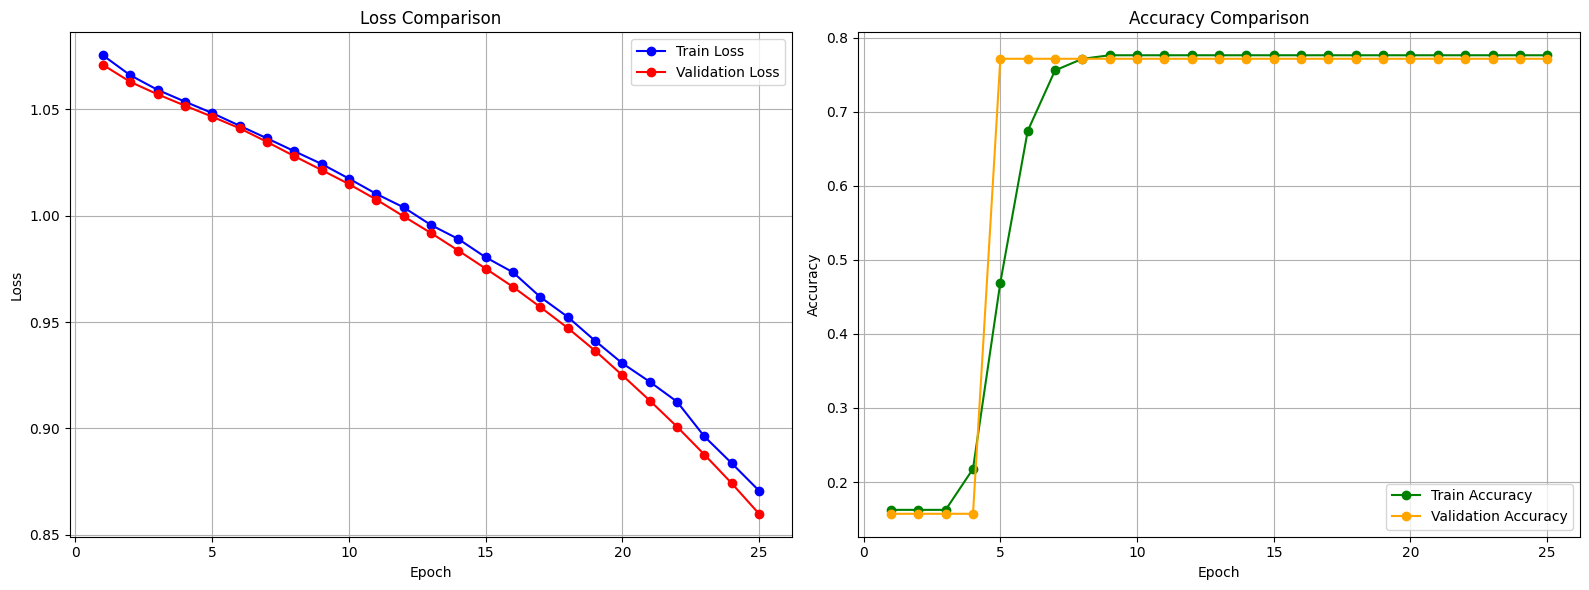

In [17]:
import matplotlib.pyplot as plt

# 1. Función para graficar las métricas
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(16, 6))

    # 1. Loss (Train and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.title("Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 2. Accuracy (Train and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.title("Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llamada a la función de graficado, con las métricas ya obtenidas
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


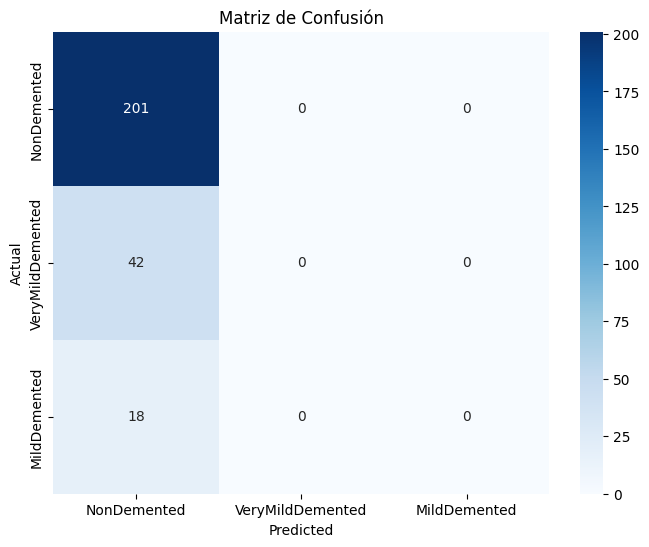

In [18]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluar el modelo en el conjunto de prueba
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Crear la matriz de confusión
labels_classes = ["NonDemented", "VeryMildDemented", "MildDemented"]
cm = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_classes, yticklabels=labels_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()


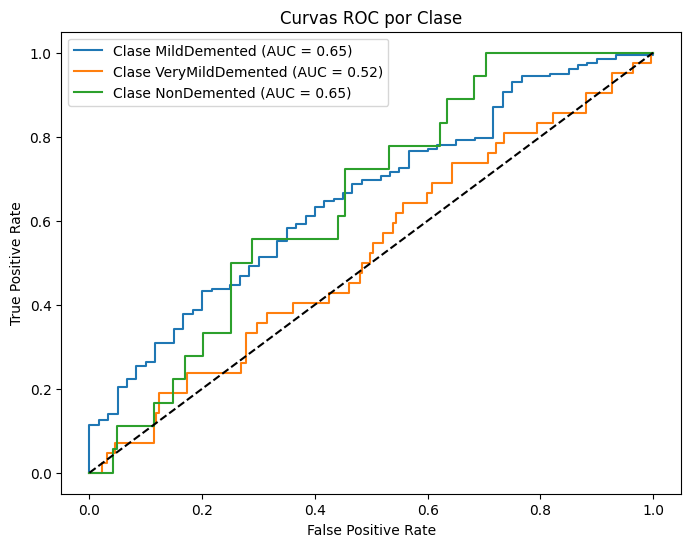

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Convertir las etiquetas en formato binario (one-vs-all) para 3 clases
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Solo 3 clases ahora
y_scores = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)  # Obtiene los logits (valores antes de softmax)
        y_scores.extend(outputs.cpu().numpy())

y_scores = np.array(y_scores)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8,6))
labels_classes = ["MildDemented", "VeryMildDemented", "NonDemented"]  # Sin "ModerateDemented"

for i in range(3):  # Ahora solo 3 clases
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {labels_classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC por Clase")
plt.legend()
plt.show()
